# Pre Processing for faster performance on Augmentation with SC

### TODO:

- ~~Find average x and y coordinates for shifting (explore SD)~~
- ~~implement a normalised dataset~~
- ~~implement validation data and test data (is there any need? this is just for validation and final results, therefore no preprocessing can be done)~~
- ~~create a more efficient merge of two image now that there is a normalised dataset~~
- ~~allow running to be executed on GPU to increase performance times~~
- now down to 3.8 seconds from 11 minutes... TLDR is idiotic np array merge, and misunderstanding of .pop() (pop() defaults to -1 index, not 0) 

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import copy
from tqdm import trange

import random
from time import perf_counter

from skimage import filters
from skimage.measure import regionprops

In [ ]:
a = {"hidden_spikes": [1, 2, 3, 4]}

In [9]:
def get_image_center_of_mass(image_array):
    threshold_value = filters.threshold_otsu(image_array)
    labeled_foreground = (image_array > threshold_value).astype(int)
    properties = regionprops(labeled_foreground, image_array)
    center_of_mass = properties[0].centroid
    weighted_center_of_mass = properties[0].weighted_centroid
    return center_of_mass, weighted_center_of_mass

def shift_y_axis(image_array, shift_value = np.random.randint(-5, 5)):
    
    new_image_array = copy.deepcopy(image_array)
    
    if shift_value > 0:
        new_image_array[0: -shift_value, :] = image_array[shift_value:,:]
        new_image_array[-shift_value:,:] = 0
    
    if shift_value < 0:
        new_image_array[-shift_value:, :] = image_array[0: shift_value, :]
        new_image_array[0:-shift_value, :] = 0
        
    return new_image_array

def shift_x_axis(image_array, shift_value = np.random.randint(-5, 5)):
    
    new_image_array = copy.deepcopy(image_array)
    
    if shift_value > 0:
        new_image_array[0: ,shift_value:] = image_array[:,: -shift_value]
        new_image_array[:, :shift_value] = 0
    
    if shift_value < 0:
        new_image_array[:,:shift_value] = image_array[:,-shift_value:]
        new_image_array[:,shift_value:] = 0
        
    return new_image_array

def combine_two_images(image_array_1, image_array_2, com_or_wcom = 0):
    """
    To combine two images by averaging them together

    :param image_array_1: first image
    :param image_array_2: second image
    :param com_or_wcom: centre of mass or weighted centre of mass
    :return: image array of combined images
    """

    com1 = np.round(get_image_center_of_mass(image_array_1)[com_or_wcom])
    com2 = np.round(get_image_center_of_mass(image_array_2)[com_or_wcom])

    difference = np.round(np.mean([com1, com2], axis = 0))

    new_image1 = shift_y_axis(shift_x_axis(image_array_1, int((difference - com1)[1])), int((difference - com1)[0]))
    new_image2 = shift_y_axis(shift_x_axis(image_array_2, int((difference - com2)[1])), int((difference - com2)[0]))
    
    combined_image = copy.deepcopy(new_image1)

    for y in range(new_image1.shape[0]):
        for x in range(new_image1.shape[1]):
            combined_image[y, x] = (combined_image[y, x] + new_image2[y, x] / 2)
    
    return combined_image

def shift_image_to_mean(image, mean_x_coordinates, mean_y_coordinates):
    """
    Takes an image, then shifts in x & y to passed mean values

    :param image: image to be shifted
    :param mean_x_coordinates: target x coordinates for central mass
    :param mean_y_coordinates: target y coordinates for central mass
    :return: image array of newly shifted image
    """
    coordinates = get_image_center_of_mass(image)

    difference = (mean_x_coordinates - round(coordinates[0][0]), 
                  mean_y_coordinates - round(coordinates[0][1]))

    return shift_y_axis(shift_x_axis(image, difference[1]), difference[0])

In [10]:
file_path = os.path.expanduser("~/data/rawSC/rawSC_80input/")
x_train = np.load(file_path + "training_x_data.npy")
y_train = np.load(file_path + "training_y_data.npy")

x_train = x_train + abs(np.floor(x_train.min()))

In [11]:
x_train.shape

(94824, 80, 100)

In [6]:
# sort x training images into y categories for blending
categories = [[] for i in range(np.max(y_train) + 1)]

for i in trange(y_train.shape[0]):
    categories[y_train[i]].append(i)

100%|██████████| 94824/94824 [00:00<00:00, 1629822.45it/s]


### analysing the dataset for normalisation 

In [14]:
x_categories = []
y_categories = []

for c in trange(len(categories)):
    x_results_array = []
    y_results_array = []
    for i in categories[c]:
        x_results_array.append(get_image_center_of_mass(x_train[i])[0][0])
        y_results_array.append(get_image_center_of_mass(x_train[i])[0][1])
    x_categories.append(x_results_array)
    y_categories.append(y_results_array)
        

100%|██████████| 35/35 [01:35<00:00,  2.73s/it]


In [15]:
# getting mean of each category (both x and y)
x_average_across = []
y_average_across = []

for c in x_categories:
    x_average_across.append(round(sum(c) / len(c)))

for c in y_categories:
    y_average_across.append(round(sum(c) / len(c)))
    

### average per class 

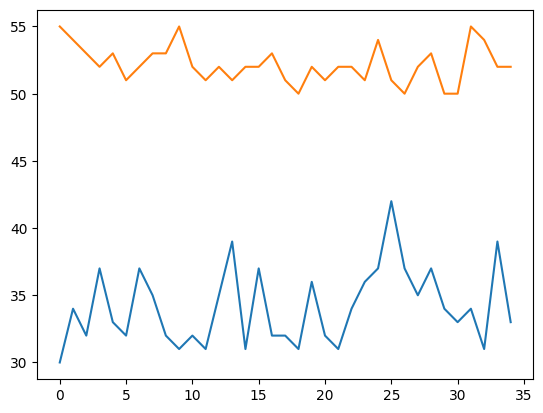

In [16]:
plt.plot(list(range(len(x_average_across))), x_average_across)
plt.plot(list(range(len(y_average_across))), y_average_across)

plt.show()

### normalising data

In [17]:
get_image_center_of_mass(x_train[categories[1][2]])

((31.65754527162978, 32.987525150905434),
 (31.69780097574653, 31.939797815698856))

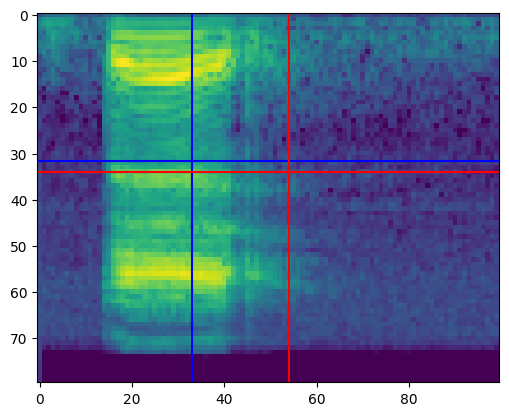

In [18]:
plt.imshow(x_train[categories[1][2]])
plt.axhline(get_image_center_of_mass(x_train[categories[1][2]])[0][0], c = 'b')
plt.axvline(get_image_center_of_mass(x_train[categories[1][2]])[0][1], c = 'b')

plt.axhline(x_average_across[1], c = 'r')
plt.axvline(y_average_across[1], c = 'r')
plt.show()

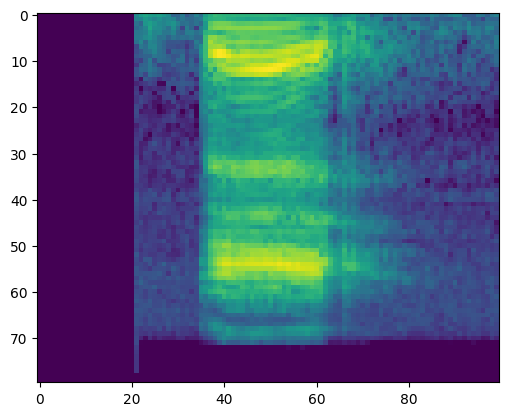

In [19]:
plt.imshow(shift_image_to_mean(x_train[categories[1][2]], x_average_across[1], y_average_across[1]))
plt.show()

In [20]:
len(categories[0])

1499

In [21]:
# loop through all categories

normalised_x_train = []
normalised_y_train = []

for c in trange(len(categories)):
    for i in range(len(categories[c])):
        normalised_x_train.append(shift_image_to_mean(x_train[categories[c][i]], 
                                                      x_average_across[c], 
                                                      y_average_across[c]))
        
        normalised_y_train.append(y_train[categories[c][i]])


100%|██████████| 35/35 [00:51<00:00,  1.47s/it]


In [22]:
assert(len(normalised_x_train) == len(x_train))
assert(len(normalised_y_train) == len(y_train))

In [23]:
# save

cache_dir=os.path.expanduser("~/data")

os.chdir(cache_dir)

# create new directory for raw HD
assert os.path.isdir("rawSC") == True  

os.chdir("rawSC")

try:
    os.mkdir("rawSC_80input_normalised")
except:
    pass
  
os.chdir("rawSC_80input_normalised/")
print("current cwd", os.getcwd())

current cwd /home/ts468/data/rawSC/rawSC_80input_normalised


In [ ]:
len(x_train)

94824

In [ ]:
len(normalised_x_train)

94824

In [ ]:
np.save("training_x_data.npy", normalised_x_train)
np.save("training_y_data.npy", normalised_y_train)
#np.save("testing_x_data.npy", testing_x_data)
#np.save("testing_y_data.npy", testing_y_data)
#np.save("validation_x_data.npy", validation_x_data)
#np.save("validation_y_data.npy", validation_y_data)

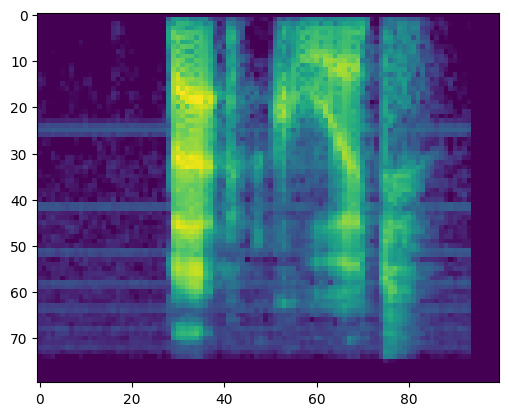

In [ ]:
plt.imshow(normalised_x_train[100])
plt.show()

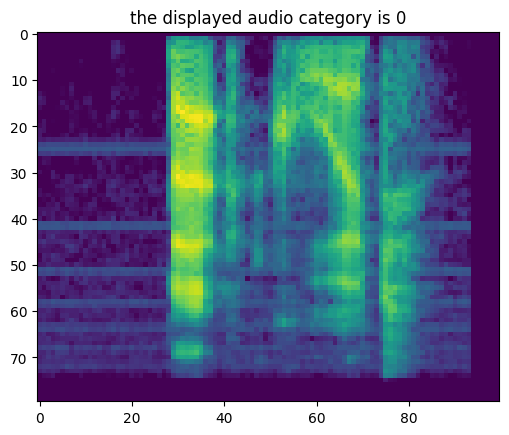

In [ ]:
index = 100

plt.imshow(normalised_x_train[index])
plt.title(f"the displayed audio category is {normalised_y_train[index]}")
plt.show()

## Speed test merging two images

In [ ]:
from augmentation_tools import combine_two_images_and_concatinate

start_time = perf_counter()

train_spikes, train_labels = combine_two_images_and_concatinate(copy.deepcopy(x_train),
                                                                y_train)

end_time = perf_counter()
print(f"Time = {end_time - start_time}s")

100%|██████████| 35/35 [11:54<00:00, 20.41s/it]


Time = 717.7878169850446s


# self sufficent (taking in only x & y training)



In [118]:
from copy import deepcopy

def combine_two_normalised_images(training_images, training_labels):
    # sort x training images into y categories for blending
    categories = [[] for i in range(np.max(training_labels) + 1)]

    for i in range(len(training_labels)):
        categories[training_labels[i]].append(i)
        
    combined_image_array = []
    combined_class_array = []

    for spoken_word in trange(len(categories)):

        random.shuffle(categories[spoken_word])

        while len(categories[spoken_word]) > 1:
            image1 = training_images[categories[spoken_word][0]]
            image2 = training_images[categories[spoken_word][1]]

            combined_image_array.append((image1 + image2) / 2)
            categories[spoken_word].pop(0)
            categories[spoken_word].pop(0)
            
            combined_class_array.append(spoken_word)
    
    combined_training_images = np.concatenate([training_images, np.array(combined_image_array)])
    
    combined_training_labels = np.concatenate([training_labels, np.array(combined_class_array)])

    # Shuffle in unison
    shuffler = np.random.permutation(len(combined_training_images))
    combined_training_images_shuffled = combined_training_images[shuffler]
    combined_training_labels_shuffled = combined_training_labels[shuffler]
    
    return combined_training_images_shuffled, combined_training_labels_shuffled

In [119]:
start_time = perf_counter()

new_array = combine_two_normalised_images(normalised_x_train, normalised_y_train)

end_time = perf_counter()
print(f"Time = {end_time - start_time}s")

100%|██████████| 35/35 [00:00<00:00, 57.17it/s]


Time = 3.8232869491912425s


In [120]:
len(normalised_x_train)

94824

In [121]:
len(new_array[0])

142227

In [122]:
normalised_x_train[0].shape

(80, 100)

In [123]:
a = np.array([[1, 2, 3], [1, 2, 3,], [1, 2, 3]])

b = np.array([[1, 2, 3], [1, 2, 3,], [1, 2, 3]])

In [74]:
print((a + b)/ 2)

[[1. 2. 3.]
 [1. 2. 3.]
 [1. 2. 3.]]


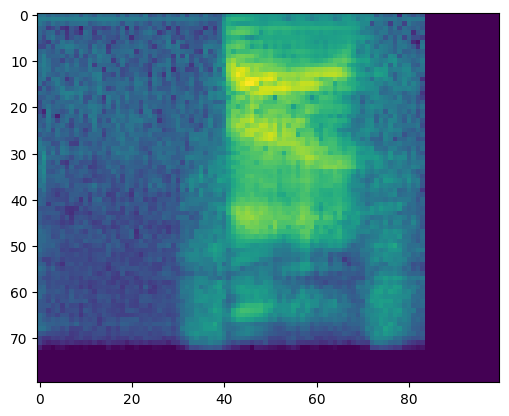

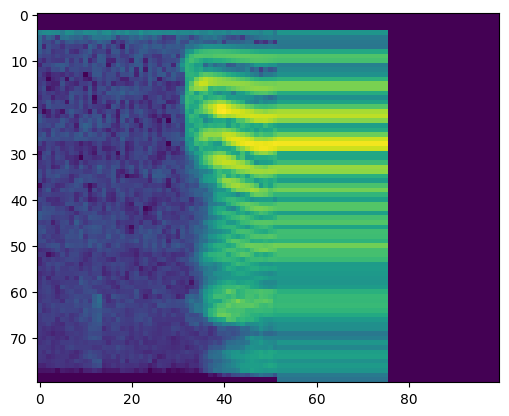

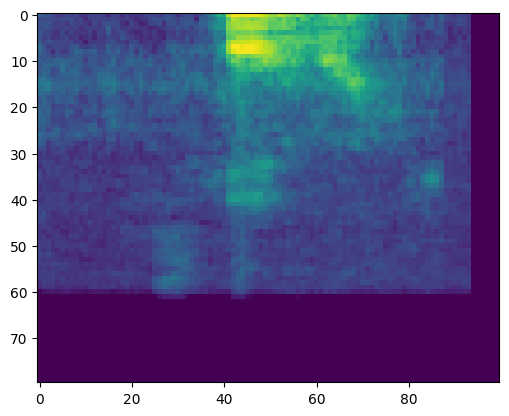

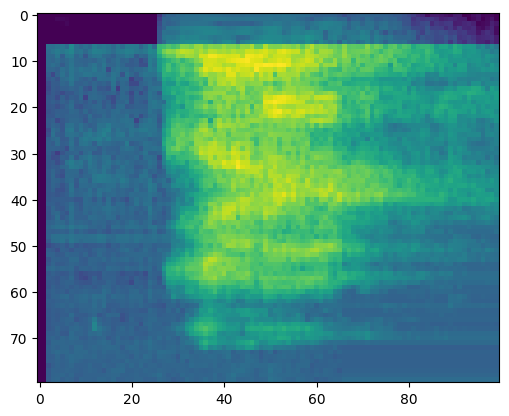

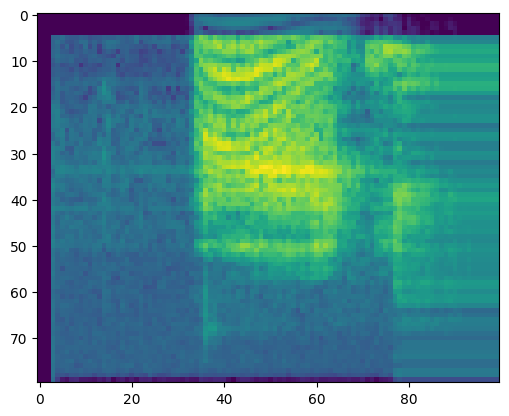

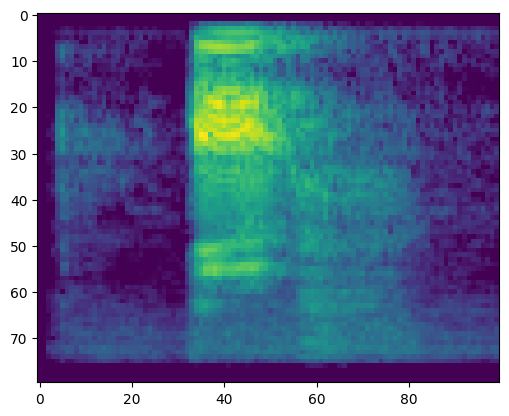

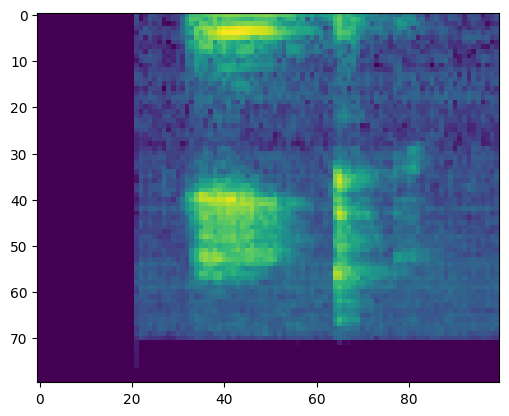

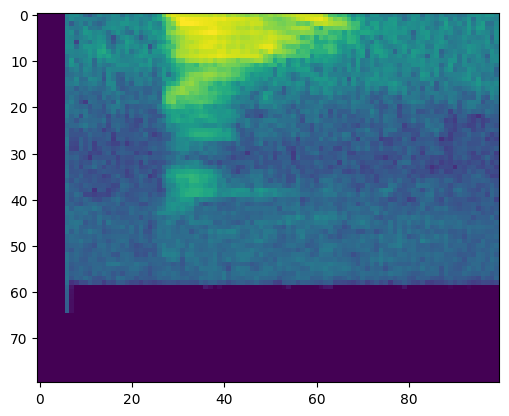

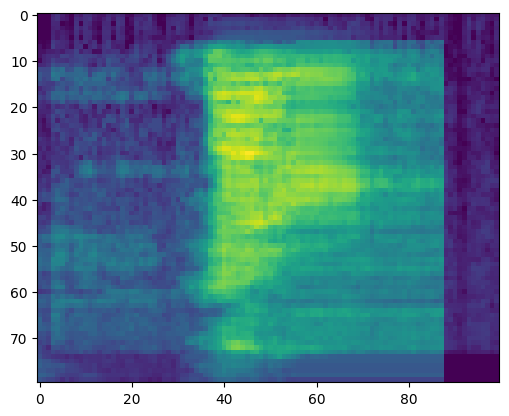

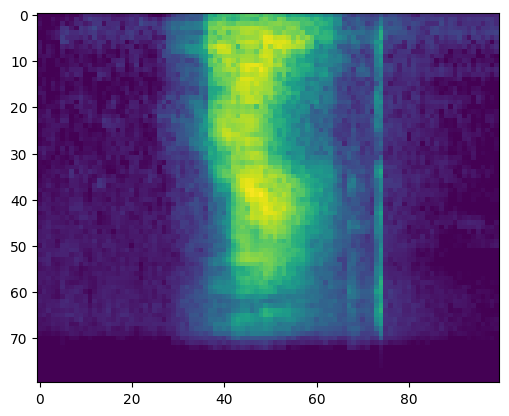

In [124]:
for i in range(10):
    plt.imshow(new_array[0][30009 + i])
    plt.show()